###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

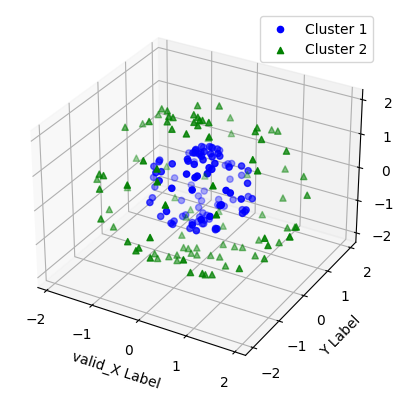

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sphere_points(center, radius, num_points):
    phi = np.random.uniform(0, np.pi, num_points)
    theta = np.random.uniform(0, 2 * np.pi, num_points)

    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    valid_y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return np.column_stack((x, valid_y, z))

# Generate example data with three clusters on a sphere
np.random.seed(42)
num_points = 100

cluster1 = generate_sphere_points([0, 0, 0], 1, num_points)
cluster2 = generate_sphere_points([0, 0, 0], 2, num_points)

# Create a figure and a 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each cluster
ax.scatter(cluster1[:, 0], cluster1[:, 1], cluster1[:, 2], c='b', marker='o', label='Cluster 1')
ax.scatter(cluster2[:, 0], cluster2[:, 1], cluster2[:, 2], c='g', marker='^', label='Cluster 2')

ax.set_xlabel('valid_X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Add a legend
ax.legend()

plt.show()


In [5]:
# initialize a model 
model = MLP(3, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 353


In [6]:
train_size = int(0.8 * num_points)
valid_size = int(0.2 * num_points)

train_X = np.vstack((cluster1[:train_size], cluster2[:train_size]))
valid_X = np.vstack((cluster1[train_size:], cluster2[train_size:]))

train_y = np.array([1 for _ in range(train_size)] + [2 for _ in range(train_size)])
valid_y = np.array([1 for _ in range(valid_size)] + [2 for _ in range(valid_size)])

print("First 10")
print(train_X[:10], train_y[:10])
print("Last 10")
print(train_X[-10:], train_y[-10:])

First 10
[[ 0.90538086  0.18115135  0.38401782]
 [-0.10095682 -0.11657959 -0.9880369 ]
 [-0.29348133  0.68579575 -0.66599767]
 [-0.95096986 -0.05126047 -0.30500604]
 [ 0.39356891 -0.25829121  0.88226366]
 [ 0.00209317  0.47068409  0.88229933]
 [-0.15344869  0.09686441  0.98339757]
 [ 0.0142327  -0.40789571 -0.91291759]
 [ 0.1261761   0.94155149 -0.31234656]
 [ 0.70278904  0.36917229 -0.60811132]] [1 1 1 1 1 1 1 1 1 1]
Last 10
[[ 0.90890355  0.66716966 -1.65190163]
 [ 1.1162214   0.12835877 -1.65456152]
 [ 0.67247324  0.45357981 -1.82812612]
 [-0.2199962  -0.49140352 -1.92616828]
 [ 1.80209914  0.86450098 -0.07125131]
 [-0.83988401  1.81507688 -0.00952712]
 [ 0.66486258 -0.97996617 -1.61171463]
 [ 1.76309828  0.25965676 -0.90777907]
 [ 0.63476125 -1.48039142 -1.18554604]
 [-0.23795347  1.17296097 -1.60235474]] [2 2 2 2 2 2 2 2 2 2]


In [7]:
# loss function
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = train_X, train_y
    else:
        ri = np.random.permutation(train_X.shape[0])[:batch_size]
        Xb, yb = train_X[ri], train_y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


total_loss, acc = loss()
print(total_loss, acc)

Value(data=3.8132948557552613, grad=0) 0.03125


In [8]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 3.8132948557552613, accuracy 3.125%
step 1 loss 0.01638540370980537, accuracy 100.0%
step 2 loss 0.016378909179446535, accuracy 100.0%
step 3 loss 0.016372476175703858, accuracy 100.0%
step 4 loss 0.016366104627988192, accuracy 100.0%
step 5 loss 0.016359794466401862, accuracy 100.0%
step 6 loss 0.01635354562173736, accuracy 100.0%
step 7 loss 0.016347358025476086, accuracy 100.0%
step 8 loss 0.016341231609787087, accuracy 100.0%
step 9 loss 0.01633516630752582, accuracy 100.0%
step 10 loss 0.016329162052232928, accuracy 100.0%
step 11 loss 0.016323218778133093, accuracy 100.0%
step 12 loss 0.01631733642013367, accuracy 100.0%
step 13 loss 0.016311514913823662, accuracy 100.0%
step 14 loss 0.016305754195472436, accuracy 100.0%
step 15 loss 0.016300054202028666, accuracy 100.0%
step 16 loss 0.016294414871119083, accuracy 100.0%
step 17 loss 0.016288836141047404, accuracy 100.0%
step 18 loss 0.016283317950793123, accuracy 100.0%
step 19 loss 0.016277860240010496, accuracy 100

TypeError: only integer scalar arrays can be converted to a scalar index

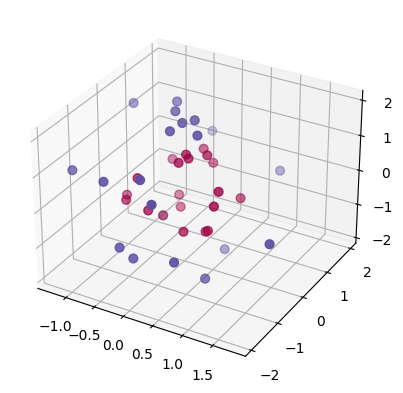

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the step size for the meshgrid
h = 0.25

# Define the ranges for each feature
x_min, x_max = valid_X[:, 0].min() - 1, valid_X[:, 0].max() + 1
y_min, y_max = valid_X[:, 1].min() - 1, valid_X[:, 1].max() + 1
z_min, z_max = valid_X[:, 2].min() - 1, valid_X[:, 2].max() + 1

# Create a meshgrid for the three features
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h),
                         np.arange(z_min, z_max, h))

# Flatten the meshgrid points and prepare inputs for the model
Xmesh = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

# Convert scores into binary values for the decision boundary
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the decision boundary
ax.scatter(valid_X[:, 0], valid_X[:, 1], valid_X[:, 2], c=valid_y, s=40, cmap=plt.cm.Spectral)
ax.scatter(inputs[Z], inputs[Z], inputs[Z], c='white', marker='.', alpha=0.2)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_zlim(zz.min(), zz.max())

plt.show()
